In [1]:
# caspian_2125.py
import os, numpy as np, rasterio
from rasterio import features
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.transform import Affine
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon, LineString
from pyproj import CRS

In [2]:
# ==== 1) 路径设置 ====
INPUT_TIF = r"gebco_2025_n46.0_s35.0_w45.0_e56.0.tif"     # 改成你的文件名
OUT_DIR   = "out_caspian_2125"
os.makedirs(OUT_DIR, exist_ok=True)


In [3]:
# ==== 2) 读入原始 GEBCO，重投影到等面积坐标系 ====
# 用全球等面积 EPSG:6933（Cylindrical Equal Area）做面积统计更靠谱
TARGET_CRS = CRS.from_epsg(6933)

with rasterio.open(INPUT_TIF) as src:
    # 计算适配的分辨率（这里取 ~1000 m/像元；你要更精细可以设 500）
    # 6933 的单位是米；我们定像元 1000 m
    res = 1000
    transform, width, height = calculate_default_transform(
        src.crs, TARGET_CRS, src.width, src.height, *src.bounds, resolution=res
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": TARGET_CRS,
        "transform": transform,
        "width": width,
        "height": height
    })

    out_path = os.path.join(OUT_DIR, "gebco_2025_equalarea_1km.tif")
    with rasterio.open(out_path, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear,
        )

In [10]:
# ==== 3) 以 -28 m 为基准，按“日均下降速率”线性外推到各年份 ====
BASE_LEVEL = -28.0                 # 2025 年里海水位（m）
BASE_YEAR  = 2025
# 在这里填你的“日均下降速率”（单位：m/day）
# 例：0.1 m/yr ≈ 0.1/365.2425 = 0.00027397 m/day；1 mm/day = 0.001 m/day
DAILY_DROP_M = 0.000274            # 示例：约等于 0.1 m/yr

YEARS_TO_EXPORT = [2035, 2050, 2075, 2125]  # 想导出的年份
EDGE_MIN_KM2 = 0.5                  # 过滤小斑块
EPS = 0.0                           # 阈值裕度，可设 0.5~1.0 减少抹边

results = []  # (year, level_m, water_area_km2)

with rasterio.open(out_path) as dem:
    dem_ma = dem.read(1, masked=True)
    prof   = dem.profile
    px_area_m2 = abs(dem.transform.a * dem.transform.e)

    # 先导出现状(2025)水面
    level_now = BASE_LEVEL
    mask_now  = (dem_ma <= (level_now - EPS))
    bin_now   = mask_now.filled(False).astype("uint8")
    prof0 = prof.copy(); prof0.update({"dtype":"uint8","nodata":0})
    present_tif = os.path.join(OUT_DIR, f"water_{BASE_YEAR}_level{-int(BASE_LEVEL)}m.tif")
    with rasterio.open(present_tif, "w", **prof0) as dst:
        dst.write(bin_now, 1)

    # 逐年份外推
    for yr in YEARS_TO_EXPORT:
        days = int(round((yr - BASE_YEAR) * 365.2425))  # 近似含闰年的天数
        level = BASE_LEVEL - DAILY_DROP_M * days        # 该年的水位（更负）

        water_mask = (dem_ma <= (level - EPS))
        water_bin  = water_mask.filled(False).astype("uint8")

        # 导出二值水面
        water_tif = os.path.join(OUT_DIR, f"water_{yr}_level{level:.2f}m.tif")
        prof_bin = prof.copy(); prof_bin.update({"dtype":"uint8","nodata":0})
        with rasterio.open(water_tif, "w", **prof_bin) as dst:
            dst.write(water_bin, 1)

        # 面积（km²）
        area_km2 = water_bin.sum() * px_area_m2 / 1e6
        results.append((yr, float(level), float(area_km2)))

        # ==== 岸线导出 ====
        shapes_gen = features.shapes(water_bin, mask=(water_bin==1), transform=dem.transform)
        polys = []
        for geom, val in shapes_gen:
            if val != 1: 
                continue
            g = shape(geom)
            if g.area * px_area_m2 / 1e6 >= EDGE_MIN_KM2:
                polys.append(g)
        if polys:
            gdf_poly = gpd.GeoDataFrame({"year":[yr]*len(polys), "level_m":[level]*len(polys)},
                                        geometry=polys, crs=TARGET_CRS)
            gdf_line = gpd.GeoDataFrame({"year":[yr]*len(polys), "level_m":[level]*len(polys)},
                                        geometry=gdf_poly.boundary, crs=TARGET_CRS)
            gdf_poly.to_file(os.path.join(OUT_DIR, f"water_poly_{yr}.geojson"), driver="GeoJSON")
            gdf_line.to_file(os.path.join(OUT_DIR, f"shoreline_{yr}.geojson"), driver="GeoJSON")

# ==== 5) 打印外推结果 ====
print("Projected water levels & areas (baseline=2025, -28 m):")
for yr, lv, area in results:
    print(f"  {yr}: level={lv:.2f} m, water_area={area:,.0f} km²")


Projected water levels & areas (baseline=2025, -28 m):
  2035: level=-29.00 m, water_area=355,196 km²
  2050: level=-30.50 m, water_area=343,861 km²
  2075: level=-33.00 m, water_area=311,312 km²
  2125: level=-38.01 m, water_area=279,463 km²


C:\Users\Jingqi\AppData\Local\Temp\ipykernel_34604\204335640.py:44: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels, loc="lower right", frameon=True)


Saved: out_caspian_2125\map_present_vs_years.png


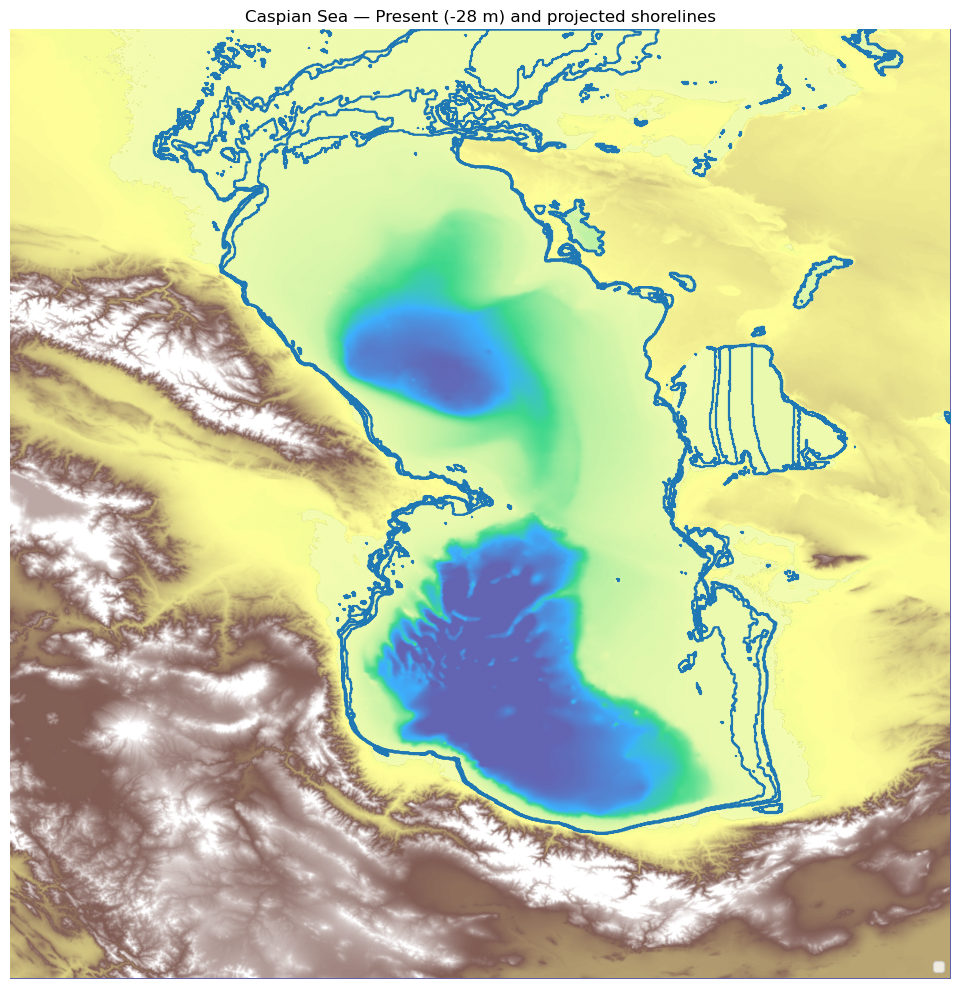

In [ ]:
import os, rasterio, geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

OUT_DIR = "out_caspian_2125"
DEM_TIF = os.path.join(OUT_DIR, "gebco_2025_equalarea_1km.tif")
YEARS   = [2035, 2050, 2075, 2125]   # 需要的年份（与你外推时导出的一致）

# 读 DEM
with rasterio.open(DEM_TIF) as src:
    Z = src.read(1)  # float32, 含 NaN
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

# 以 0 m 为中心的双端色带：陆地(>0)与水下(<0)一图看清
vmin = np.nanpercentile(Z,  2)
vmax = np.nanpercentile(Z, 98)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(Z, extent=extent, origin="upper", norm=norm, cmap="terrain")
ax.set_title("Caspian Sea — Present (-28 m) and projected shorelines")
ax.axis("off")

# 现状水面（-28 m 基准）：半透明蓝覆盖（可选）
present = (Z <= -28.0) & np.isfinite(Z)
ax.imshow(np.where(present, 1, np.nan), extent=extent, origin="upper", cmap="Blues", alpha=0.25)

# 叠加各年份岸线
handles = []
labels  = []
for yr in YEARS:
    shp = os.path.join(OUT_DIR, f"shoreline_{yr}.geojson")
    if not os.path.exists(shp):
        print(f"[skip] {shp} 不存在")
        continue
    gdf = gpd.read_file(shp)
    ln = gdf.plot(ax=ax, linewidth=1.6)
    handles.append(ln)
    labels.append(str(yr))

# 简易图例
if handles:
    ax.legend(handles, labels, loc="lower right", frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "map_present_vs_years.png"), dpi=300)
print("Saved:", os.path.join(OUT_DIR, "map_present_vs_years.png"))


Saved: out_caspian_2125\map_lake_two_blues_land_multiband.png


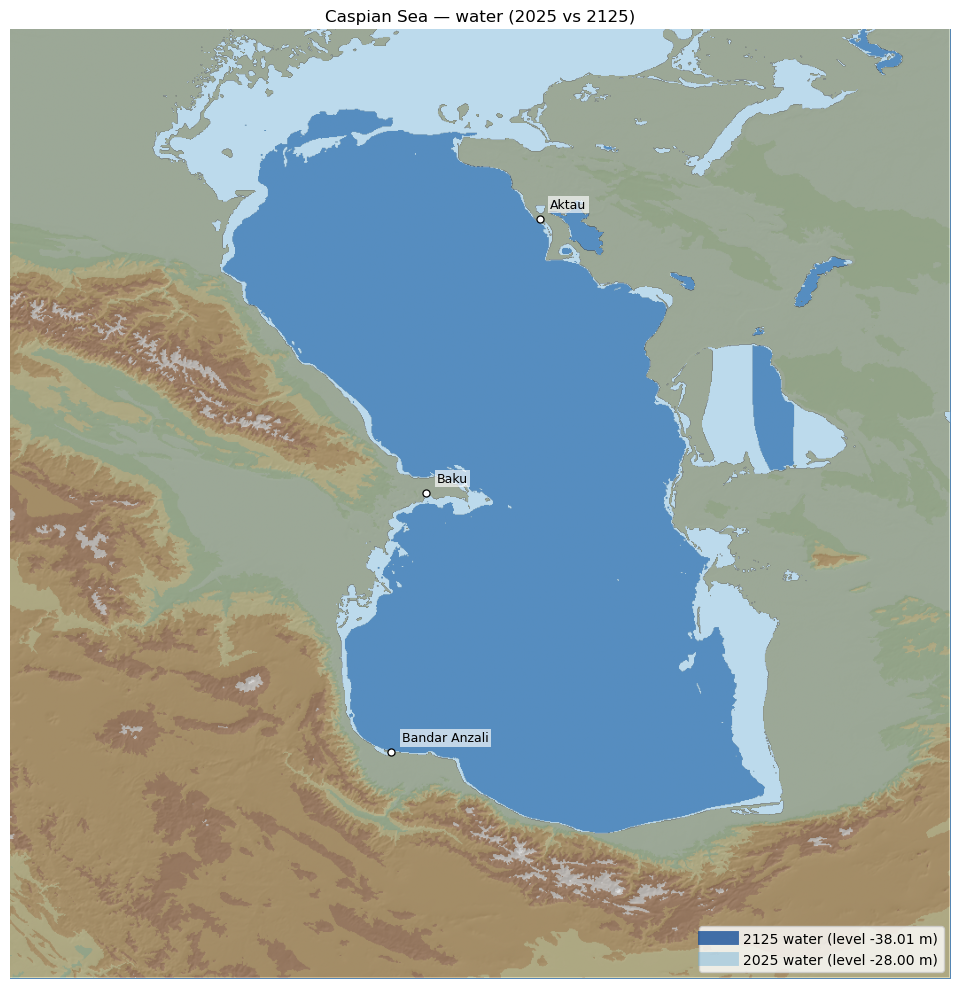

In [20]:
import os, numpy as np, rasterio, geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

OUT_DIR = "out_caspian_2125"
DEM_TIF = os.path.join(OUT_DIR, "gebco_2025_equalarea_1km.tif")

# ——— 基准与速率（用来得到 2125 水位） ———
BASE_YEAR  = 2025
BASE_LEVEL = -28.0         # m（现状水位）
DAILY_DROP = 0.000274      # m/day ≈ 0.10 m/yr，可改
TARGET_YEAR = 2125
EPS = 0.5                  # 近岸安全裕度（0~1）

with rasterio.open(DEM_TIF) as src:
    Z = src.read(1)  # float32, 含 NaN
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    crs = src.crs

valid = np.isfinite(Z)

# ——— 计算 2025 与 2125 的水域掩膜 ———
days = int(round((TARGET_YEAR - BASE_YEAR) * 365.2425))
level_2125 = BASE_LEVEL - DAILY_DROP * days
mask_2025  = (Z <= (BASE_LEVEL  - EPS)) & valid
mask_2125  = (Z <= (level_2125 - EPS)) & valid

# 基于 -28 m 判陆地
land = (Z > (BASE_LEVEL - EPS)) & np.isfinite(Z)

# 1) 多级分层：边界（单位 m）
# 低地更细：-28~200、200~500、500~1000、1000~2000、2000~3000、3000~4000、>4000
bins = np.array([-28, 200, 500, 1000, 2000, 3000, 4000, np.inf])

# 只对陆地像元分级
land_vals = np.full_like(Z, np.nan, dtype=float)
idx = np.digitize(np.where(land, Z, np.nan), bins) - 1  # 0..6
land_vals[land] = idx[land]

# 柔和配色（低地灰绿→草绿→土黄→赭→褐→浅灰白→纯白）
land_cmap = ListedColormap([
    (190/255,206/255,183/255,1.0),  # -28–200 灰绿
    (178/255,200/255,164/255,1.0),  # 200–500 淡草绿
    (213/255,206/255,156/255,1.0),  # 500–1000 土黄
    (200/255,170/255,120/255,1.0),  # 1000–2000 赭
    (181/255,141/255,110/255,1.0),  # 2000–3000 褐
    (225/255,220/255,215/255,1.0),  # 3000–4000 浅灰白
    (1.0,    1.0,    1.0,    1.0),  # >4000 雪白
])

# 2) hillshade（柔和，减少“塑料感”）
dx = abs(src.transform.a); dy = abs(src.transform.e)
Zfill = np.where(np.isfinite(Z), Z, np.nanmedian(Z))
gy, gx = np.gradient(Zfill, dy, dx)
slope  = np.arctan(np.hypot(gx, gy))
aspect = np.arctan2(-gx, gy)
az, alt = np.deg2rad(315), np.deg2rad(45)
hs = np.sin(alt)*np.cos(slope) + np.cos(alt)*np.sin(slope)*np.cos(az - aspect)
hs = (hs - np.nanmin(hs)) / (np.nanmax(hs) - np.nanmin(hs))
hs[~land] = np.nan  # 只在陆地显示阴影

# 3) 绘制：先陆地分层，再叠浅阴影，然后两层湖水
fig, ax = plt.subplots(figsize=(10,10))

# 陆地分层
ax.imshow(land_vals, extent=extent, origin="upper",
          cmap=land_cmap, vmin=0, vmax=len(land_cmap.colors)-1)

# 柔和阴影：很低 alpha，避免喧宾夺主
ax.imshow(hs, extent=extent, origin="upper",
          cmap="Greys", vmin=0.25, vmax=0.95, alpha=0.25)

# 湖面两种统一蓝
from matplotlib.colors import ListedColormap as LCM
deep_blue = LCM([(  8/255,  69/255, 148/255, 0.75)])  # 2125
soft_blue = LCM([(107/255, 174/255, 214/255, 0.45)])  # 2025
m2125 = np.where(mask_2125, 1, np.nan)
m2025 = np.where(mask_2025, 1, np.nan)
ax.imshow(m2125, extent=extent, origin="upper", cmap=deep_blue, vmin=0, vmax=1)
ax.imshow(m2025, extent=extent, origin="upper", cmap=soft_blue, vmin=0, vmax=1)

ax.set_title("Caspian Sea — water (2025 vs 2125)")
ax.axis("off")

# === 只加入湖水图例 + 城市标注 ===
from matplotlib.lines import Line2D
from pyproj import Transformer

# 1) 仅湖水图例（用你前面定义的两种蓝色）
lake_legend = [
    Line2D([0],[0], lw=10, color=deep_blue.colors[0], label=f"2125 water (level {level_2125:.2f} m)"),
    Line2D([0],[0], lw=10, color=soft_blue.colors[0], label=f"2025 water (level {BASE_LEVEL:.2f} m)")
]
ax.legend(handles=lake_legend, loc="lower right", frameon=True, title=None)

# 2) 标注三个大城市（经纬度 → 当前地图投影）
cities = [
    ("Baku",   49.8671, 40.4093),
    ("Aktau",  51.1975, 43.6510),
    ("Bandar Anzali", 49.4625, 37.4727),
]
trans = Transformer.from_crs("EPSG:4326", crs, always_xy=True)

for name, lon, lat in cities:
    x, y = trans.transform(lon, lat)
    ax.scatter(x, y, s=26, c="white", edgecolors="black", linewidths=0.9, zorder=6)
    ax.text(
        x + 12000, y + 12000, name, fontsize=9, color="black", zorder=6,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.65, pad=1.5)
    )

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "map_lake_two_blues_land_multiband.png"), dpi=300)
print("Saved:", os.path.join(OUT_DIR, "map_lake_two_blues_land_multiband.png"))
